- **Librerías**

In [1]:
import cdsapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from netCDF4 import Dataset
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
from matplotlib import cm
import matplotlib as mpl
import pytz
from pytz import timezone
from matplotlib import font_manager as fm
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pylab as pl
from pyproj import Proj



import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

# Personalizar graficas
plt.style.use('default')
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight']='normal'

In [2]:
path_font=r"G:\My drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

In [3]:
# Funiciones 
def roundBy(x, base=10):
    return int(base * round(float(x)/base))

def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return lon, lat


def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)
    return ind

# Descargar los datos de ERA5

Please note that the ERA5 native grid of online CDS is 0.25°x0.25° (atmosphere), 0.5°x0.5° (ocean waves), mean, spread and members: 0.5°x0.5° (atmosphere), 1°x1° (ocean waves). ERA5-Land: 0.1°x0.1°. So this will be returned by default.

https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5#HowtodownloadERA5-4-DownloadERA5familydatathroughtheCDSAPI

Se descargan los datos de la base de datos ERA 5

Descargar Api: https://cds.climate.copernicus.eu/api-how-to

In [4]:
# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             'mean_wave_direction', 'peak_wave_period', 'significant_height_of_combined_wind_waves_and_swell',
#         ],
#         'year': [ '2021',
#         ],
#         'month': [
#         '10', '11',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': 
#             '00:00/ 01:00/ 02:00/03:00/ 04:00/ 05:00/06:00/ 07:00/ 08:00/ 09:00/ 10:00/ 11:00/12:00/ 13:00/ 14:00/15:00/ 16:00/ 17:00/18:00/ 19:00/ 20:00/21:00/ 22:00/23:00'
#         ,
#         'area':[
#             '12.875','278','12.25','278.625',
#         ],
#         'grid':[
#             '0.125','0.125',
#         ],
#         'step' :"0"
#     },
#     'data_wave_MG.nc')

In [5]:
data = Dataset('data_wave_MG.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'mwd': <class 'netCDF4._netCDF4.Variable'>
 int16 mwd(time, latitude, longitude)
     scale_factor: 0.001146957496767753
     add_offset: 46.49030605692666
     _FillValue: -32767
     missing_value: -32767
     units: Degree true
     long_name: Mean wave directio

In [6]:
%%time
lat_wave = np.array(data.variables['latitude'][:]);
lon_wave = np.array(data.variables['longitude'][:]);
nctime_wave = np.array(data.variables['time'][:]);
t_unit_wave = data.variables['time'].units;
t_cal_wave = data.variables['time'].calendar;
time_wave = num2date(nctime_wave,units=t_unit_wave,calendar=t_cal_wave);#Date time
hs = np.array(data.variables['swh'][:]);
tp = np.array(data.variables['pp1d'][:]);
direc = np.array(data.variables['mwd'][:]);


# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
col_zone = timezone('GMT')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wave])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time_wave = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time_wave

CPU times: total: 109 ms
Wall time: 453 ms


array([datetime.datetime(2021, 10, 1, 0, 0),
       datetime.datetime(2021, 10, 1, 1, 0),
       datetime.datetime(2021, 10, 1, 2, 0), ...,
       datetime.datetime(2021, 11, 30, 21, 0),
       datetime.datetime(2021, 11, 30, 22, 0),
       datetime.datetime(2021, 11, 30, 23, 0)], dtype=object)

In [7]:
date_ini = datetime(2021,11,1,0) # Parámetro a variar
date_fin = datetime(2021,11,14,16) # Parámetro a variar
ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wave.shape)

[ 744 1072]
(328,)


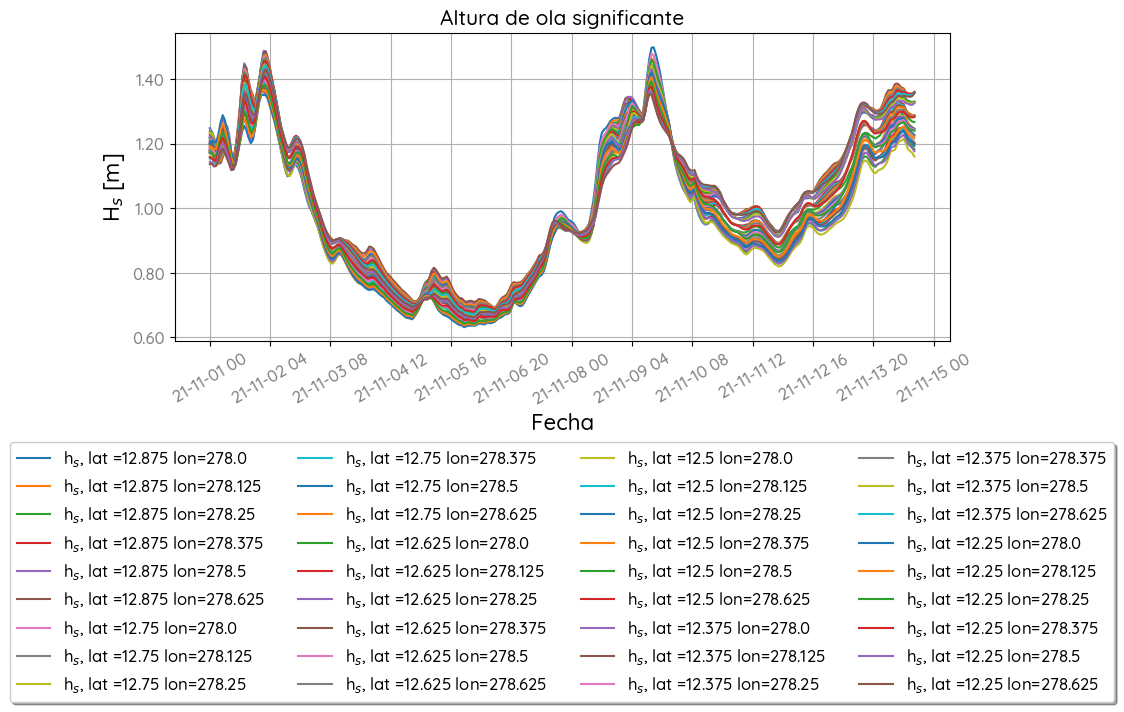

In [8]:
#Grafica de las alturas de ola significante 
hourticks = ((time_d3d_wave[-1]-time_d3d_wave[0]).days*24 +(time_d3d_wave[-1]-time_d3d_wave[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wave[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(10,4))
for i in range(len(lat_wave)):
    for j in range(len(lon_wave)):
        ax.plot(time_d3d_wave, hs[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'h$_s$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
#         ax.plot(time_d3d_wave, v10_wave[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('H$_{s}$ [m]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Altura de ola significante',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

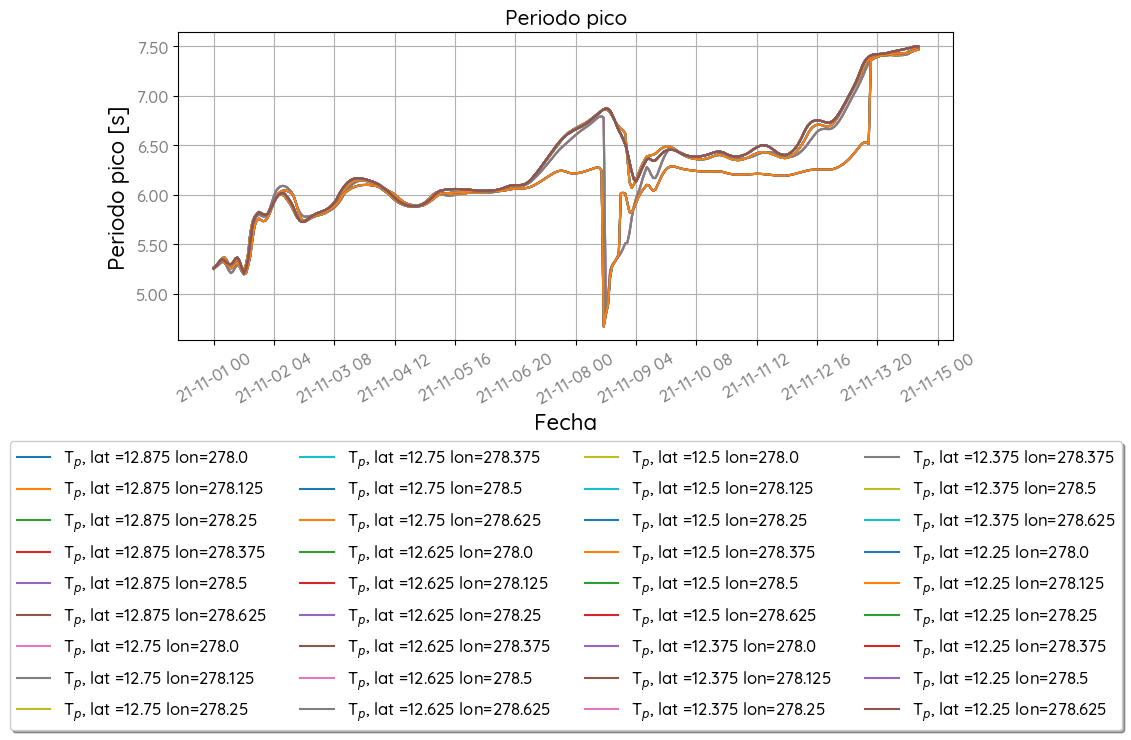

In [9]:
hourticks = ((time_d3d_wave[-1]-time_d3d_wave[0]).days*24 +(time_d3d_wave[-1]-time_d3d_wave[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wave[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(10,4))
for i in range(len(lat_wave)):
    for j in range(len(lon_wave)):
        ax.plot(time_d3d_wave, tp[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'T$_p$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
#         ax.plot(time_d3d_wave, v10_wave[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wave[i])+ ' lon='+str(lon_wave[j]))
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('Periodo pico [s]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Periodo pico',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

In [10]:
def TEPAR_files_swan(filename,lon, lat, Latitud, Longitud, time_wave, hs, tp, direc , date_ini = datetime(2021,10,28,0), date_fin = datetime(2021,11,14,16)):
    """
    filename: Nombre del archivo
    Lon: Coordenada longitudinal del punto de interés
    Lat: Coordenada latitudinal del punto de interés
    Latitud: Serie de coordenadas latitudinales
    Longitud: Serie de coordenadas longitudinales
    date_ini: fecha inicial de la serie de datos
    date_fin: Fecha final de la serie de datos
    """
    in_lat = np.where((Latitud == lat))[0]
    in_lon = np.where((Longitud == lon))[0]
    ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
    
    time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
    str_time_wave =[time_d3d_wave[i].strftime("%Y%m%d.%H%M") for i in range( len(time_d3d_wave))]
    Hs = hs[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Hs = [Hs[i][0] for i in range(len(Hs))]
    Tp = tp[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Tp = [Tp[i][0] for i in range(len(Tp))]
    Direc = direc[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Direc = [Direc[i][0] for i in range(len(Direc))]
    Des_direc = list(np.ones(shape=len(Direc))*40)
    Dir_Param = {'Time':str_time_wave, 'Hs': Hs, 'Tp': Tp, 'Direc': Direc, 'Des_Dirc': Des_direc}
    df_data = pd.DataFrame(data = Dir_Param)
    with open (filename+'.bnd', "w") as f:
        f.write("TPAR \n")
        np.savetxt(f,df_data,fmt =('%s  %7.9f  %8.9f  %9.9f  %5.1f'))
    return df_data

In [11]:
date_fin

datetime.datetime(2021, 11, 14, 16, 0)

In [12]:
# Note:
Boundary = 'Norte'
longitudes = [278.125,278.250, 278.375, 278.5]
lat = 12.750
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),longitudes[i], lat, lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = date_ini, date_fin = date_fin)

In [13]:
# Sur:
Boundary = 'Sur'
longitudes = [278.125,278.250, 278.375, 278.5]
lat = 12.375
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),longitudes[i], lat, lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = date_ini, date_fin = date_fin)

In [14]:
# Oeste:
Boundary = 'Oeste'
latitudes = [12.375, 12.5, 12.625, 12.750]
lon = 278.125
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),lon, latitudes[i], lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = date_ini, date_fin = date_fin)

In [15]:
# Este:
Boundary = 'Este'
latitudes = [12.375, 12.5, 12.625, 12.750]
lon = 278.125
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),lon, latitudes[i], lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = date_ini, date_fin = date_fin)

# Archivo de vientos 

Descarga de datos

In [41]:
# DESCARGAR DATOS DE VIENTOS DE ERA5
# %%time
# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '10m_u_component_of_wind', '10m_v_component_of_wind',
#         ],
#         'year': [
#              '2021',
#         ],
#         'month': [
            
#             '10', '11', 
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area':[
#             '12.875','278','12.25','278.625',
#         ],
#         'grid':[
#             '0.125','0.125',
#         ],
#     },
#     'data_wind_10_11_125.nc')

In [42]:
data = Dataset('data_wind_10_11_125.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'u10': <class 'netCDF4._netCDF4.Variable'>
 int16 u10(time, latitude, longitude)
     scale_factor: 0.00018869329346164382
     add_offset: -4.233119510058825
     _FillValue: -32767
     missing_value: -32767
     units: m s**-1
     long_name: 10 metre U wind com

In [43]:
%%time
lat = np.array(data.variables['latitude'][:])
lon = np.array(data.variables['longitude'][:])
nctime = np.array(data.variables['time'][:])
t_unit = data.variables['time'].units
t_cal = data.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
u10 = np.array(data.variables['u10'][:])
v10 = np.array(data.variables['v10'][:])

CPU times: total: 31.2 ms
Wall time: 24.4 ms


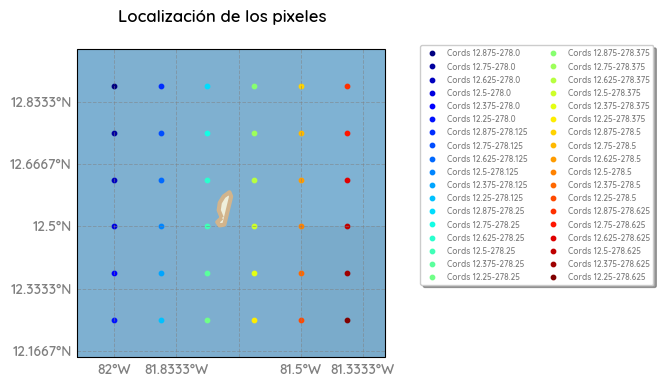

In [44]:
# lon = 360+Cords[:,0]
# lat = Cords[:,1]
fig = plt.figure(figsize = (7,4))
ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.stock_img()
ax1.add_feature(cf.LAND, zorder= 10)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
# ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')

colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
i = 0
for loni in (lon):
    for lati in (lat):
        ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
        i = i +1

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}


ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')

prop2.set_size(6)
_= fig.legend(loc='upper center', bbox_to_anchor=(0.95, 0.9),
          fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
fig.suptitle('Localización de los pixeles',size=12,fontproperties=prop2);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

In [45]:
utc = pytz.utc
col_zone = timezone('America/Bogota')
# col_zone = timezone('GMT')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time.shape

(1464,)

In [46]:
date_ini = datetime(2021,11,1,0) # Parámetro a variar
date_fin = datetime(2021,11,14,17) # Parámetro a variar
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d_wind = time[ind_ini_fin[0]:ind_ini_fin[1]]
hours = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*24)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/3600) for i in range (0,len(time_d3d_wind))])
minutes = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*1440)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/60) for i in range (0,len(time_d3d_wind))])
data_u10 = u10[ind_ini_fin[0]:ind_ini_fin[1],:,:]
data_v10 = v10[ind_ini_fin[0]:ind_ini_fin[1],:,:]

In [47]:
time_d3d_wind

array([datetime.datetime(2021, 11, 1, 0, 0),
       datetime.datetime(2021, 11, 1, 1, 0),
       datetime.datetime(2021, 11, 1, 2, 0),
       datetime.datetime(2021, 11, 1, 3, 0),
       datetime.datetime(2021, 11, 1, 4, 0),
       datetime.datetime(2021, 11, 1, 5, 0),
       datetime.datetime(2021, 11, 1, 6, 0),
       datetime.datetime(2021, 11, 1, 7, 0),
       datetime.datetime(2021, 11, 1, 8, 0),
       datetime.datetime(2021, 11, 1, 9, 0),
       datetime.datetime(2021, 11, 1, 10, 0),
       datetime.datetime(2021, 11, 1, 11, 0),
       datetime.datetime(2021, 11, 1, 12, 0),
       datetime.datetime(2021, 11, 1, 13, 0),
       datetime.datetime(2021, 11, 1, 14, 0),
       datetime.datetime(2021, 11, 1, 15, 0),
       datetime.datetime(2021, 11, 1, 16, 0),
       datetime.datetime(2021, 11, 1, 17, 0),
       datetime.datetime(2021, 11, 1, 18, 0),
       datetime.datetime(2021, 11, 1, 19, 0),
       datetime.datetime(2021, 11, 1, 20, 0),
       datetime.datetime(2021, 11, 1, 21, 0)

In [25]:
#Se hace el recorte del vector
q1=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[0])[0]
q2=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[-1])[0]
# with open ("wind_octubre_noviembre_2022.wnd",'w') as f:# Aquí se crea el archivo.txt
#     for i in range(q1[0],q2[0]):
#         f.write("%s\n" % time_d3d_wind[i].strftime("%Y%m%d %H%M%S"))
#         np.savetxt(f,data_u10[i,:,:])#,fmt='%10.4f')
#         np.savetxt(f,data_v10[i,:,:])#,fmt='%10.4f')

In [28]:
air_prees = np.ones(shape = data_u10.shape)*101300.0

with open ("ERA5_air_press.amp",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("Time = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[0].strftime("%Y-%m-%d %H:%M:%S") + " -05:00 \n")
        # np.savetxt(f,data_u10[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,air_prees[i,:,:][::-1])#,fmt='%10.4f')

In [29]:
with open ("ERA5_x_wind.amu",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("Time = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[0].strftime("%Y-%m-%d %H:%M:%S") + " -05:00 \n")
        # np.savetxt(f,data_u10[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,data_u10[i,:,:][::-1])#,fmt='%10.4f')

In [30]:
with open ("ERA5_y_wind.amv",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("Time = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[0].strftime("%Y-%m-%d %H:%M:%S") + " -05:00 \n")
#         np.savetxt(f,data_u10[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,data_v10[i,:,:][::-1])#,fmt='%10.4f')

# HEAT FLUX 

In [16]:
# Descargar Datos
# %%time
# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             'total_cloud_cover', '2m_dewpoint_temperature','2m_temperature', 'surface_solar_radiation_downwards',
#         ],
#         'year': [
#              '2021',
#         ],
#         'month': [
            
#             '10', '11', 
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area':[
#             '12.875','278','12.25','278.625',
#         ],
#         'grid':[
#             '0.125','0.125',
#         ],
#     },
#     'data_heat_flux_ocean_10_11_125.nc')

In [48]:
data = Dataset('data_heat_flux_ocean_10_11_125.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'tcc': <class 'netCDF4._netCDF4.Variable'>
 int16 tcc(time, latitude, longitude)
     scale_factor: 1.525958854494026e-05
     add_offset: 0.49999567826351254
     _FillValue: -32767
     missing_value: -32767
     units: (0 - 1)
     long_name: Total cloud cover
 

In [49]:
%%time
lat = np.array(data.variables['latitude'][:])
lon = np.array(data.variables['longitude'][:])
nctime = np.array(data.variables['time'][:])
t_unit = data.variables['time'].units
t_cal = data.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
tcc = np.array(data.variables['tcc'][:]) # total cloud cover
d2m = np.array(data.variables['d2m'][:]) # dwepoint temperature
t2m = np.array(data.variables['t2m'][:]) # 2m temperature
ssr = np.array(data.variables['ssrd'][:]) # surface solar radiation


# Ajustar a la zona horaria de San Andrés 
utc = pytz.utc
# zones = pytz.all_timezones # Vew all timezones
# print(zones)
# col_zone = timezone('America/Bogota')
col_zone = timezone('GMT')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time

CPU times: total: 0 ns
Wall time: 40.1 ms


array([datetime.datetime(2021, 10, 1, 0, 0),
       datetime.datetime(2021, 10, 1, 1, 0),
       datetime.datetime(2021, 10, 1, 2, 0), ...,
       datetime.datetime(2021, 11, 30, 21, 0),
       datetime.datetime(2021, 11, 30, 22, 0),
       datetime.datetime(2021, 11, 30, 23, 0)], dtype=object)

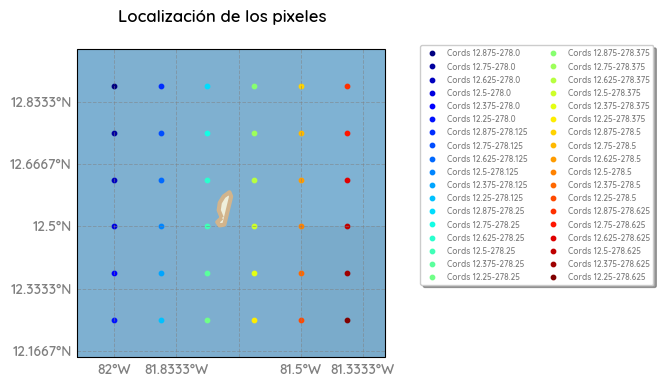

In [50]:
# lon = 360+Cords[:,0]
# lat = Cords[:,1]
fig = plt.figure(figsize = (7,4))
ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.stock_img()
ax1.add_feature(cf.LAND, zorder= 10)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
# ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')

colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
i = 0
for loni in (lon):
    for lati in (lat):
        ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
        i = i +1

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}


ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')

prop2.set_size(6)
_= fig.legend(loc='upper center', bbox_to_anchor=(0.95, 0.9),
          fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
fig.suptitle('Localización de los pixeles',size=12,fontproperties=prop2);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

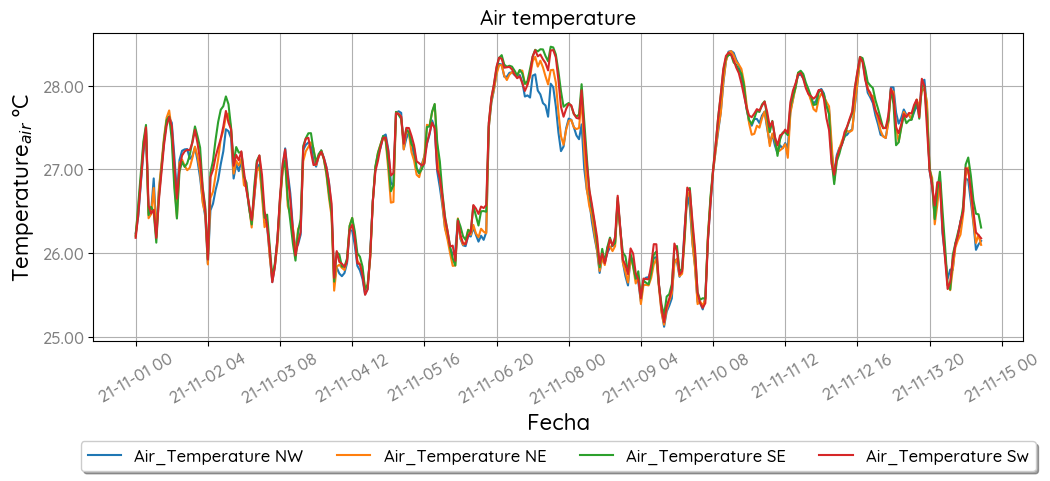

In [51]:
hourticks = ((time_d3d_wind[-1]-time_d3d_wind[0]).days*24 +(time_d3d_wind[-1]-time_d3d_wind[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wind[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12
df_cords = pd.DataFrame({'Lon':lon, 'Lat':lat})

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],2,2]-273.15, label = 'Air_Temperature NW')
ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],3,2]-273.15, label = 'Air_Temperature NE')
ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],3,3]-273.15, label = 'Air_Temperature SE')
ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],2,3]-273.15, label = 'Air_Temperature Sw')



# ax.plot(time_d3d_wind, d2m[ind_ini_fin[0]:ind_ini_fin[1],2,2], label = 'Dewpoint temperature')
# ax.plot(time_d3d_wind, t2m[ind_ini_fin[0]:ind_ini_fin[1],2,2], label = 'Temperature')
# ax.plot(time_d3d_wind, ssr[ind_ini_fin[0]:ind_ini_fin[1],2,2], label = 'Solar radiation')

# ax.plot(time_d3d, ft_west_a, label = 'f$_t$_1', ms=5, color = 'k')
# ax.plot(time_d3d, ft_south_b, label = 'f$_t$_2', ms=5)
# ax.plot(time_d3d, ft_east_b, label = 'f$_t$_3', ms=5, color = 'c')
# ax.plot(time_d3d, ft_north_a, label = 'f$_t$_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('Temperature$_{air}$ ºC',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# fig.suptitle("Gráficas", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Air temperature',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

In [52]:
date_ini = datetime(2021,11,1,0) # Parámetro a variar
date_fin = datetime(2021,11,14,16) # Parámetro a variar
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d_wind = time[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wind.shape)


minutes = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*1440)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/60) for i in range (0,len(time_d3d_wind))])
df_data_heat = pd.DataFrame({'minutes':minutes,'tcc':tcc[ind_ini_fin[0]:ind_ini_fin[1],2,2]*100,'t2m':t2m[ind_ini_fin[0]:ind_ini_fin[1],2,2]-273.15, 
'd2m':d2m[ind_ini_fin[0]:ind_ini_fin[1],2,2]-273.15})
df_data_heat['hum'] =(4.596*np.exp(17.27*df_data_heat['d2m']/(237.3+df_data_heat['d2m'])))*100/(4.596*np.exp(17.27*df_data_heat['t2m']/(237.3+df_data_heat['t2m'])))
df_heat = df_data_heat[['minutes','hum','t2m','tcc']]

[ 744 1072]
(328,)


In [53]:
df_heat

,minutes,hum,t2m,tcc
0,0.0,90.489102,26.349000,64.938705
1,60.0,90.743773,26.357911,69.745475
2,120.0,89.470222,26.290660,85.111881
3,180.0,88.715026,26.206535,96.294108
4,240.0,89.660021,26.170296,95.526550
...,...,...,...,...
323,19380.0,89.273435,26.113619,98.593728
324,19440.0,89.447555,26.200476,98.483859
325,19500.0,89.051424,26.380368,97.887209
326,19560.0,89.080058,26.493365,96.352094


# HEAT FLUX MODEL HYCOM

In [55]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
data = Dataset(path+'\Hycom_oct21_nov15_2021_ATMOS_DATA.nc','r')
print(data.variables)

{'latitude': <class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (6,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'longitude': <class 'netCDF4._netCDF4.Variable'>
float64 longitude(longitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (4,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: days since 1900-12-31 00:00:00
    time_origin: 1900-12-31 00:00:00
    calendar: gregorian
unlimited dimensions: 
current shape = (601,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'airtmp': <class 'netCDF4._netCDF4.Variable'>
float64 airtmp(longitude, latitude, time)
    units: degC
    missing_value: -30000
unlimited dimensions: 
current shape = (4, 6, 601)
filling on, default _FillValue of 9.969209968386869e+36 used, 'vapmix': <class 'netCDF4._netCDF4.Variable'>
float64 vapmix(lo

In [56]:
lat = np.array(data.variables['latitude'][:])
lon = np.array(data.variables['longitude'][:])
nctime = np.array(data.variables['time'][:])
t_unit = data.variables['time'].units
t_cal = data.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
time = np.array([datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])

#------ Cambiar referencia de tiempo a utm-----------------------------------
# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('GMT')
# col_zone = timezone('America/Bogota')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])


#-----------Variables-------------------------------------
air_temp = np.array(data.variables['airtmp'][:])
SH =  np.array(data.variables['vapmix'][:])
solar_flux = np.array(data.variables['shwflx'][:])
airpres = np.array(data.variables['airprs'])
u10_wind = np.array(data.variables['u10'])
v10_wind = np.array(data.variables['v10'])
print(air_temp.shape, SH.shape, solar_flux.shape, airpres.shape, lon.shape, lat.shape, time.shape)

(4, 6, 601) (4, 6, 601) (4, 6, 601) (4, 6, 601) (4,) (6,) (601,)


In [57]:
print(lon[1]-lon[0])
print(lat[1]-lat[0])

0.20454545319080353
0.20442926706777698


In [58]:
date_ini = datetime(2021,11,1,0) # Parámetro a variar
date_fin = datetime(2021,11,14,16) # Parámetro a variar
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_heat = time[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_heat.shape)

[264 592]
(328,)


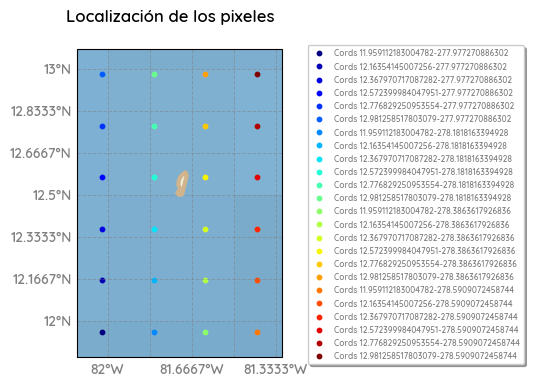

In [59]:
# lon = 360+Cords[:,0]
# lat = Cords[:,1]
fig = plt.figure(figsize = (7,4))
ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.stock_img()
ax1.add_feature(cf.LAND, zorder= 10)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
# ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
i = 0
for loni in (lon):
    for lati in (lat):
        ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
        i = i +1
# i = 0
# for loni, lati in zip (lon, lat):
#     ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(loni)+'-'+str(lati), color = colors_cm[i])
#     i=i+1
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}


ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')

prop2.set_size(6)
_= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
          fancybox=True, shadow=True, ncol=1, fontsize = 8,prop=prop2, labelcolor = 'gray')
fig.suptitle('Localización de los pixeles',size=12,fontproperties=prop2);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

In [60]:
# Observar el comportamiento de las variables 
# hourticks = ((time_heat[-1]-time_heat[0]).days*24 +(time_heat[-1]-time_heat[0]).seconds/3600+12) # Mover parámetro 12
# xticks_time = np.array([time_heat[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12


# for i in range(len(lat)):
#     for j in range(len(lon)):
#         fig, ax = plt.subplots(figsize=(12,4))
#         ax.plot(time_heat, air_temp[j,i,ind_ini_fin[0]:ind_ini_fin[1]], label = 'lat ='+str(lat[i]) + ' lon=' + str(lon[j]))
#         ax.set_xticks(xticks_time)
#         date_format = mdates.DateFormatter('%y-%m-%d %H')
#         ax.xaxis.set_major_formatter(date_format)
#         ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
#         ax.set_ylabel ('Temperature [degC]',size=16,fontproperties=prop1)
#         ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
#         for label in ax.get_xticklabels():
#             label.set_fontproperties(prop1)
#             label.set_color('gray')
#             label.set_size(12)
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#         ax.set_title('Air temperarure',size = 15,fontproperties=prop1)   # Subtítulo de la figura
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
#                 fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
#         plt.xticks(rotation=30)
#         ax.grid(True)

In [61]:
# Observar el comportamiento de las variables 

# hourticks = ((time_heat[-1]-time_heat[0]).days*24 +(time_heat[-1]-time_heat[0]).seconds/3600+12) # Mover parámetro 12
# xticks_time = np.array([time_heat[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

# for i in range(len(lat)):
#     for j in range(len(lon)):
#         fig, ax = plt.subplots(figsize=(12,4))
#         ax.plot(time_heat, solar_flux[j,i,ind_ini_fin[0]:ind_ini_fin[1]], label = 'lat ='+str(lat[i]) + ' lon=' + str(lon[j]))
#         ax.set_xticks(xticks_time)
#         date_format = mdates.DateFormatter('%y-%m-%d %H')
#         ax.xaxis.set_major_formatter(date_format)
#         ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
#         ax.set_ylabel ('Shortwave flux [W/m$^2$]',size=16,fontproperties=prop1)
#         ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
#         for label in ax.get_xticklabels():
#             label.set_fontproperties(prop1)
#             label.set_color('gray')
#             label.set_size(12)
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#         ax.set_title('Flujo de radiación de onda corta',size = 15,fontproperties=prop1)   # Subtítulo de la figura
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
#                 fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
#         plt.xticks(rotation=30)
#         ax.grid(True)

In [62]:
# Observar el comportamiento de las variables 

# hourticks = ((time_heat[-1]-time_heat[0]).days*24 +(time_heat[-1]-time_heat[0]).seconds/3600+12) # Mover parámetro 12
# xticks_time = np.array([time_heat[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

# for i in range(len(lat)):
#     for j in range(len(lon)):
#         fig, ax = plt.subplots(figsize=(12,4))
#         ax.plot(time_heat, u10_wind[j,i,ind_ini_fin[0]:ind_ini_fin[1]], label = 'lat ='+str(lat[i]) + ' lon=' + str(lon[j]))
#         ax.plot(time_heat, v10_wind[j,i,ind_ini_fin[0]:ind_ini_fin[1]], label = 'lat ='+str(lat[i]) + ' lon=' + str(lon[j]))

#         ax.set_xticks(xticks_time)
#         date_format = mdates.DateFormatter('%y-%m-%d %H')
#         ax.xaxis.set_major_formatter(date_format)
#         ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
#         ax.set_ylabel ('velocity [m/m]',size=16,fontproperties=prop1)
#         ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
#         for label in ax.get_xticklabels():
#             label.set_fontproperties(prop1)
#             label.set_color('gray')
#             label.set_size(12)
#         ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#         ax.set_title('Vel_wind',size = 15,fontproperties=prop1)   # Subtítulo de la figura
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
#                 fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
#         plt.xticks(rotation=30)
#         ax.grid(True)

## Archivo de vientos 

In [29]:
lon_wind = lon
lat_wind = lat[2:5]
print(lon_wind, lat_wind)

[277.97727089 278.18181634 278.38636179 278.59090725] [12.36797072 12.57239998 12.77682925]


In [30]:
x_min, y_min = proj_ZONE17(np.nanmin(lon_wind), np.nanmin(lat_wind)) 
print(x_min, y_min)

x_max, y_max = proj_ZONE17(np.nanmax(lon_wind), np.nanmax(lat_wind))
print(x_max, y_max)

x_max, y_mean = proj_ZONE17(np.nanmax(lon_wind), lat_wind[1])
print(x_max, y_mean)

dx = (lon[1]-lon[0])*111100
dy = (lat[1]-lat[0])*111100
print(dx, dy)

388814.530399728 1367456.2189612284
455597.7774442886 1412491.3770020816
455562.36024670093 1389884.3485101592
22724.999849498272 22712.091571230023


In [31]:
lat[2:5]

array([12.36797072, 12.57239998, 12.77682925])

In [32]:
date_ini = datetime(2021,11,1,0) # Parámetro a variar
date_fin = datetime(2021,11,14,17) # Parámetro a variar
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d_wind = time[ind_ini_fin[0]:ind_ini_fin[1]]
hours = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*24)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/3600) for i in range (0,len(time_d3d_wind))])
minutes = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*1440)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/60) for i in range (0,len(time_d3d_wind))])
data_u10 = u10_wind[:,2:5,ind_ini_fin[0]:ind_ini_fin[1]]
data_v10 = v10_wind[:,2:5,ind_ini_fin[0]:ind_ini_fin[1]]
air_presure = airpres[:,2:5,ind_ini_fin[0]:ind_ini_fin[1]]*10000

In [33]:
# air_presure = np.ones(shape = (4,3,len(time_d3d_wind)))*101300.0

In [34]:
q1=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[0])[0]
q2=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[-1])[0]
with open ("xy_wind_d3dflow.wnd",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("TIME = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[0].strftime("%Y-%m-%d %H:%M:%S") + " +00:00 \n")
        np.savetxt(f,data_u10.T[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,data_v10.T[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,air_presure.T[i,:,:])

In [35]:
q1=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[0])[0]
q2=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[-1])[0]
with open ("HYCOM_x_wind.amu",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("TIME = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[0].strftime("%Y-%m-%d %H:%M:%S") + " -05:00 \n")
        np.savetxt(f,data_u10.T[i,:,:])#,fmt='%10.4f')
        # np.savetxt(f,data_v10.T[i,:,:])#,fmt='%10.4f')

In [36]:
q1=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[0])[0]
q2=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[-1])[0]
with open ("HYCOM_y_wind.amv",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("TIME = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[0].strftime("%Y-%m-%d %H:%M:%S") + " -05:00 \n")
        # np.savetxt(f,data_u10.T[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,data_v10.T[i,:,:])#,fmt='%10.4f')

In [37]:
q1=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[0])[0]
q2=np.where(np.asarray(time_d3d_wind[:])==time_d3d_wind[-1])[0]
with open ("HYCOM_press_wind.amp",'w') as f:# Aquí se crea el archivo.txt
    for i in range(q1[0],q2[0]):
        f.write("TIME = %5.1f" % minutes[i] + " minutes since " + "%s" % time_d3d_wind[0].strftime("%Y-%m-%d %H:%M:%S") + " -05:00 \n")
        # np.savetxt(f,data_u10.T[i,:,:])#,fmt='%10.4f')
        # np.savetxt(f,data_v10.T[i,:,:])#,fmt='%10.4f')
        np.savetxt(f,air_presure.T[i,:,:])

In [38]:
time_d3d_wind 

array([datetime.datetime(2021, 11, 1, 0, 0),
       datetime.datetime(2021, 11, 1, 1, 0),
       datetime.datetime(2021, 11, 1, 2, 0),
       datetime.datetime(2021, 11, 1, 3, 0),
       datetime.datetime(2021, 11, 1, 4, 0),
       datetime.datetime(2021, 11, 1, 5, 0),
       datetime.datetime(2021, 11, 1, 6, 0),
       datetime.datetime(2021, 11, 1, 7, 0),
       datetime.datetime(2021, 11, 1, 8, 0),
       datetime.datetime(2021, 11, 1, 9, 0),
       datetime.datetime(2021, 11, 1, 10, 0),
       datetime.datetime(2021, 11, 1, 11, 0),
       datetime.datetime(2021, 11, 1, 12, 0),
       datetime.datetime(2021, 11, 1, 13, 0),
       datetime.datetime(2021, 11, 1, 14, 0),
       datetime.datetime(2021, 11, 1, 15, 0),
       datetime.datetime(2021, 11, 1, 16, 0),
       datetime.datetime(2021, 11, 1, 17, 0),
       datetime.datetime(2021, 11, 1, 18, 0),
       datetime.datetime(2021, 11, 1, 19, 0),
       datetime.datetime(2021, 11, 1, 20, 0),
       datetime.datetime(2021, 11, 1, 21, 0)

## Ocena model

In [63]:
df_heat_ocean_model = pd.DataFrame({'time':time_heat, 'Air_temp':air_temp.T[ind_ini_fin[0]:ind_ini_fin[1],3,1]})
df_heat_ocean_model.set_index('time', inplace=True)
df_heat['t2m'] = df_heat_ocean_model.Air_temp.values

In [64]:
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
file_name = 'data_heat_flux.tem'
np.savetxt(path+'/'+file_name, df_heat.values, delimiter='  ', fmt = "%.7f" ) 

## Humedad relativa

$RH = 100 \frac{w}{w_s} \approx  0.236pq[\exp(\frac{17.67(T-T_0)}{T-29.65})]$


Saturation vapor pressure $e_s$ is calculated from a given temperature $T$ (in $K$) by using the Clausius-Clapeyron relation.  $e_s(T) = e_s(T_0)\times \exp \left(\frac{L}{R_w}\left(\frac{1}{T_0} - \frac{1}{T}\right)\right)$ (#eq:1) where $e_s(T_0) = 6.11 hPa$ is the saturation vapor pressure at a reference temperature $T_0 = 273.15 K$, $L = 2.5 \times 10^6 J/kg$ is the latent heat of evaporation for water, and $R_w = \frac{1000R}{M_w} = 461.52 J/(kg K)$ is the specific gas constant for water vapor (where $R = 8.3144621 J / (mol K)$ is the molar gas constant and $M_w = 18.01528 g/mol$ is the molar mass of water vapor). More details refer to @Shaman-Kohn:2009.


An alternative way to calculate saturation vapor pressure $e_s$ is per the equation proposed by @Murray:1967. $e_s = 6.1078\exp{\left[\frac{a(T - 273.16)}{T - b}\right]} $ where $\begin{cases} a = 21.8745584 \ b = 7.66 \end{cases}$ over ice; $\begin{cases} a = 17.2693882 \ b = 35.86 \end{cases}$ over water.

The resulting $e_s$ is in hectopascal ($hPa$) or millibar ($mb$).

Vapor Pressure $e$ {-}
When given dew point $T_d$ (in $K$), the actual vapor pressure $e$ can be computed by plugging $T_d$ in place of $T$ into equation \@ref(eq:1). The resulting $e$ is in millibar ($mb$).

Relative Humidity $\psi$ {-}
Relative humidity $\psi$ is defined as the ratio of the partial water vapor pressure $e$ to the saturation vapor pressure $e_s$ at a given temperature $T$, which is usually expressed in $\%$ as follows $ \psi = \frac{e}{e_s}\times 100$ (#eq:2) 

Therefore, when given the saturation vapor pressure $e_s$ and relative humidity $\psi$, the partial water vapor pressure $e$ can also be easily calculated per equation \@ref(eq:2). $ e = \psi e_s $ The resulting $e$ is in $Pa$.

Absolute Humidity $\rho_w$ {-}
Absolute humidity $\rho_w$ is the total amount of water vapor $m_w$ present in a given volume of air $V$. The definition of absolute humidity can be described as follows $$ \rho_w = \frac{m_w}{V} $$

Water vapor can be regarded as ideal gas in the normal atmospheric temperature and atmospheric pressure. Its equation of state is $ e = \rho_w R_w T $ (#eq:3) 

Absolute humidity $\rho_w$ is derived by solving equation \@ref(eq:3). $$ \rho_w = \frac{e}{R_w T} $$ The resulting $\rho_w$ is in $kg/m^3$.

Mixing Ratio $\omega$ {-}
Mixing ratio $\omega$ is the ratio of water vapor mass $m_w$ to dry air mass $m_d$, expressed in equation as follows $ \omega = \frac{m_w}{m_d} $

The resulting $\omega$ is in $kg/kg$.

Specific Humidity $q$ {-}
Specific humidity $q$ is the ratio of water vapor mass $m_w$ to the total (i.e., including dry) air mass $m$ (namely, $m = m_w + m_d$). The definition is described as $ q = \frac{m_w}{m} = \frac{m_w}{m_w + m_d} = \frac{\omega}{\omega + 1} $

Specific humidity can also be expressed in following way. $ q = \frac{\frac{M_w}{M_d}e}{p - (1 - \frac{M_w}{M_d})e}$ (#eq:4) where $M_d = 28.9634 g/mol$ is the molar mass of dry air; $p$ represents atmospheric pressure and the standard atmospheric pressure is equal to $101,325 Pa$. The details of formula derivation refer to Wikipedia.

Substitute $\frac{M_w}{M_d} \approx 0.622$ into equation \@ref(eq:4) and simplify the formula. $ q \approx \frac{0.622e}{p - 0.378e} $ (#eq:5) The resulting $q$ is in $kg/kg$.

Hence, by solving equation \@ref(eq:5) we can obtain the equation for calculating the partial water vapor pressure $e$ given the specific humidity $q$ and atmospheric pressure $p$.

$ e \approx \frac{qp}{0.622 + 0.378q}  $  (#eq:6) Substituting equations \@ref(eq:1) and \@ref(eq:6) into equation \@ref(eq:2), we can get the equation for converting specific humidity $q$ into relative humidity $\psi$ at a given temperature $T$ and under atmospheric pressure $p$.

In [40]:
airpres*100

array([[[1192.29412079, 1213.38787079, 1211.04412079, ...,
         1144.24724579, 1139.55974579, 1244.63787079],
        [1239.95037079, 1241.90349579, 1239.55974579, ...,
          998.93474579, 1064.55974579, 1059.87224579],
        [1052.05974579, 1049.32537079, 1066.12224579, ...,
         1084.87224579, 1079.79412079, 1082.13787079],
        [1079.40349579, 1086.04412079, 1090.34099579, ...,
         1299.71599579, 1311.82537079, 1319.24724579],
        [1296.20037079, 1310.26287079, 1318.07537079, ...,
         1282.13787079, 1289.55974579, 1286.04412079],
        [1290.34099579, 1297.76287079, 1290.73162079, ...,
         1061.82537079, 1099.71599579, 1086.82537079]],

       [[1057.91912079, 1047.37224579, 1084.09099579, ...,
         1066.12224579, 1070.02849579, 1068.07537079],
        [1070.80974579, 1065.73162079, 1066.51287079, ...,
          960.26287079,  957.91912079,  950.49724579],
        [ 965.73162079,  966.51287079,  958.70037079, ...,
          868.07537079,  87

In [41]:
q = SH/(SH+1)
# es = 6.11*np.exp((17.6293883*((air_temp+273.15)-273.16))/((air_temp+273.15)-35.86))

es = 6.11*np.exp((2.5*10**6/461.52)*((1/273.15)-1/(air_temp+273.15)))
e = SH*airpres*100/(0.622+0.378*SH)

RH = (e/es)*100

In [42]:
RH

array([[[ 89.54981958,  90.98902662,  90.81776601, ...,  85.96249334,
          86.22072349,  90.96178808],
        [ 91.14800098,  92.1915492 ,  93.23378889, ...,  76.54601523,
          81.00901565,  80.84400594],
        [ 80.50850509,  80.45665058,  81.32853312, ...,  79.17557399,
          79.30156509,  80.19901414],
        [ 81.85994238,  79.12447596,  80.53580099, ..., 100.33051418,
         100.985609  , 101.55475999],
        [100.88735357, 101.78463327, 102.22943236, ...,  95.69430522,
          96.68135903,  95.3893734 ],
        [ 95.94618845,  96.83639566,  96.91248829, ...,  74.97430054,
          76.05252213,  75.29424004]],

       [[ 73.7858226 ,  73.90683392,  75.08348432, ...,  80.47037475,
          80.42628956,  79.94259253],
        [ 79.94605105,  80.61742054,  80.42181837, ...,  73.27016725,
          72.80615212,  72.83852886],
        [ 73.77305517,  73.57928765,  73.51693332, ...,  63.07276794,
          63.44654796,  63.51836972],
        [ 63.04060624,  63

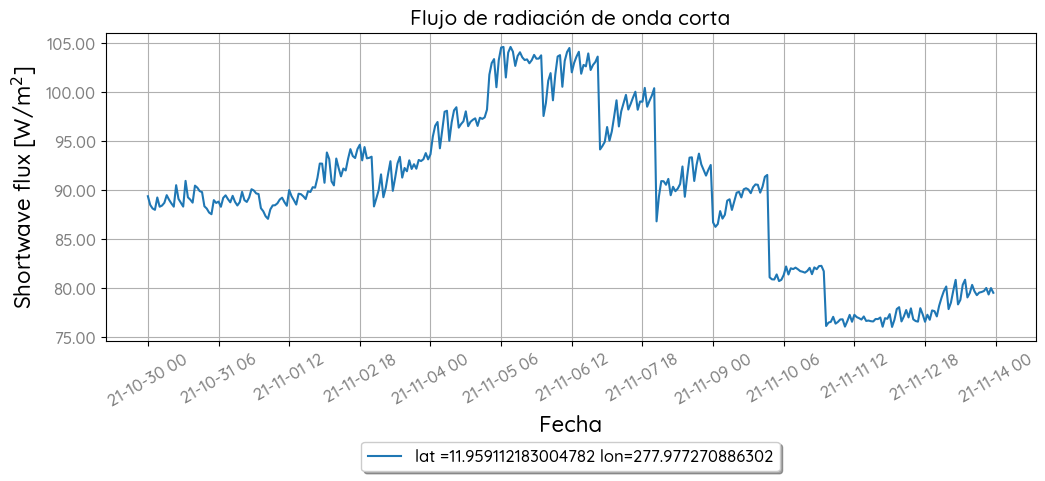

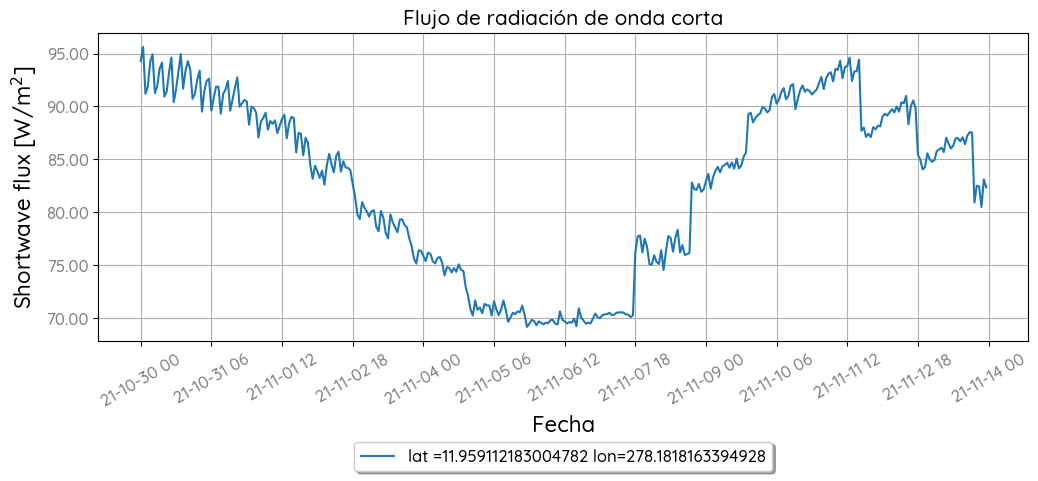

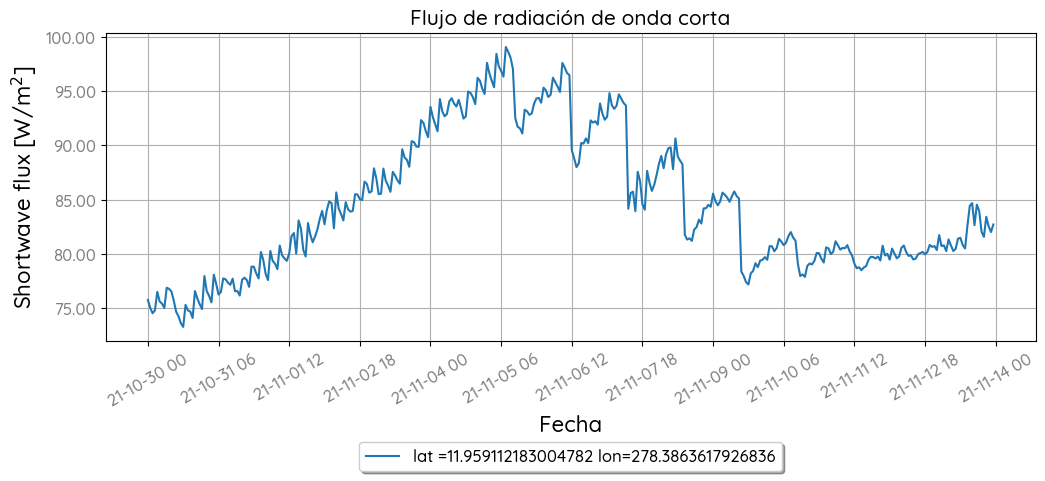

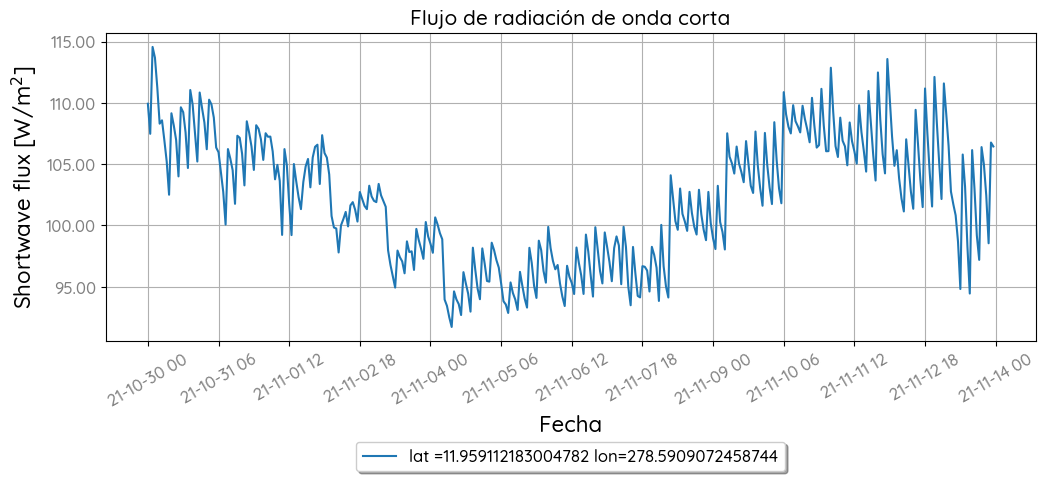

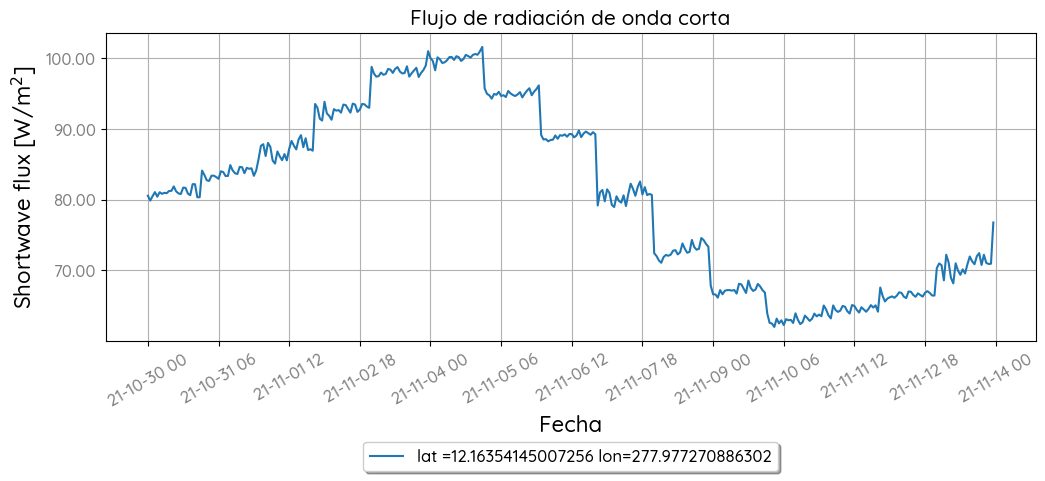

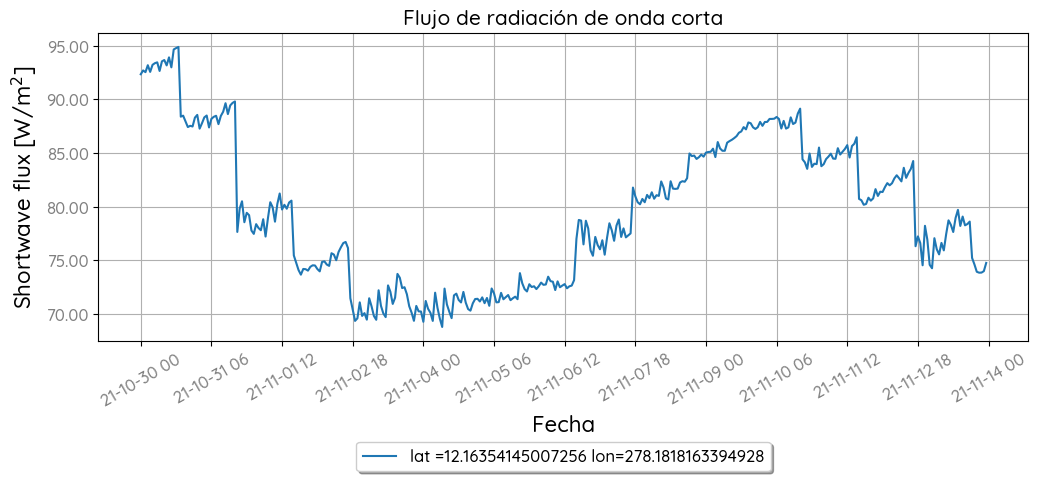

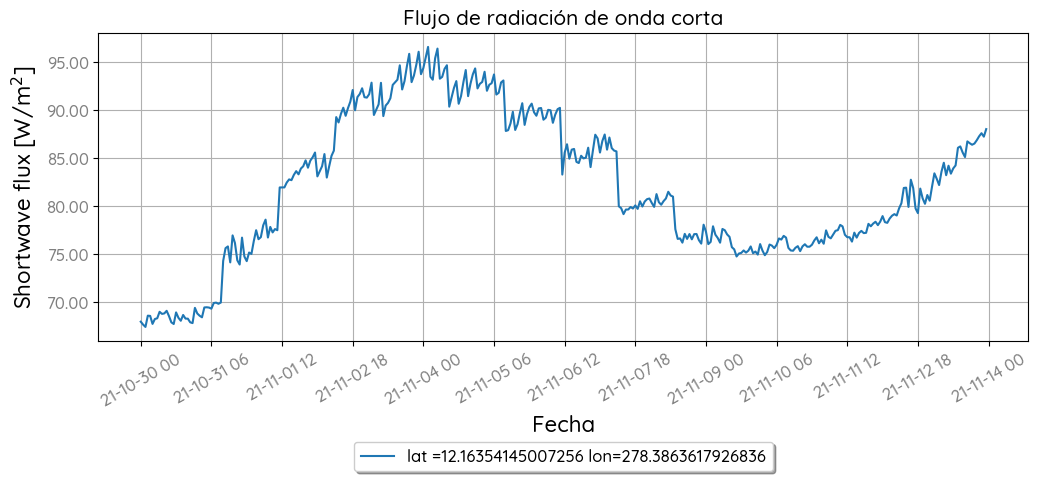

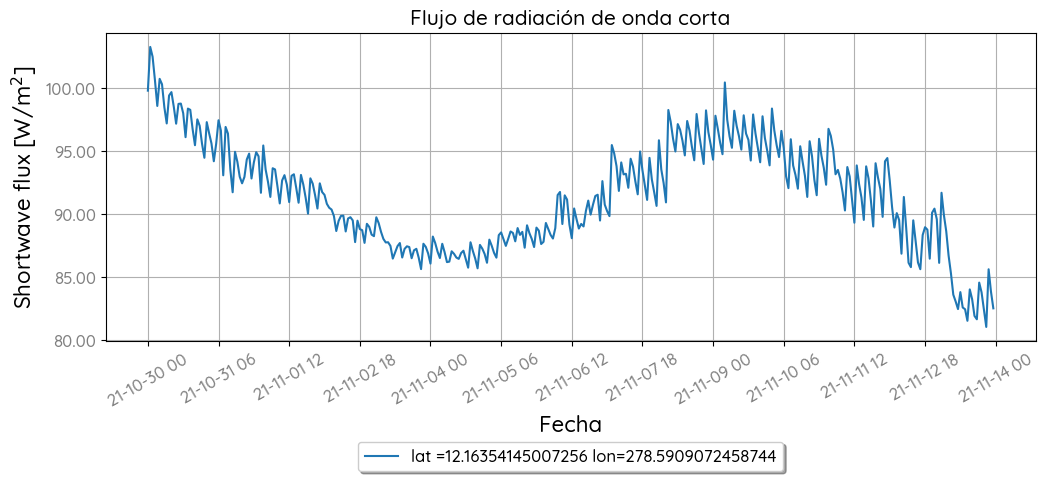

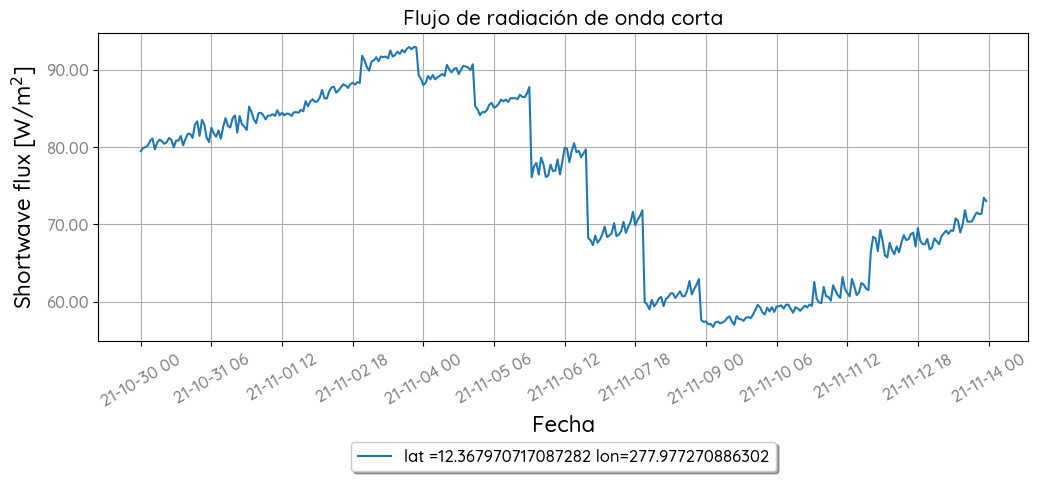

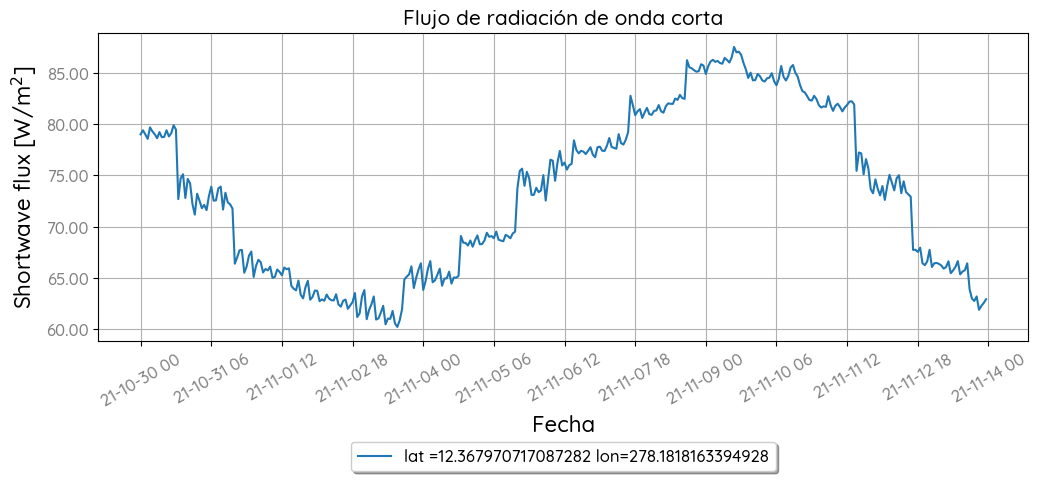

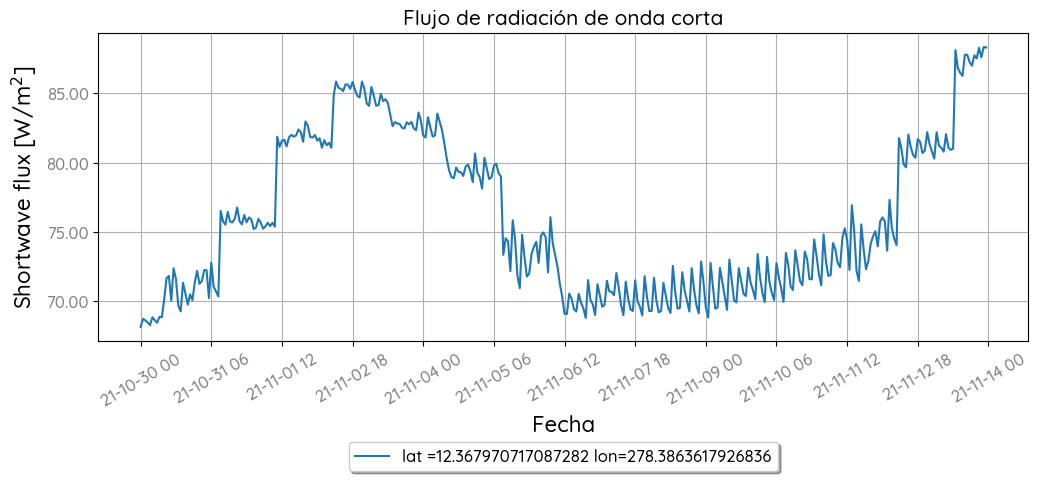

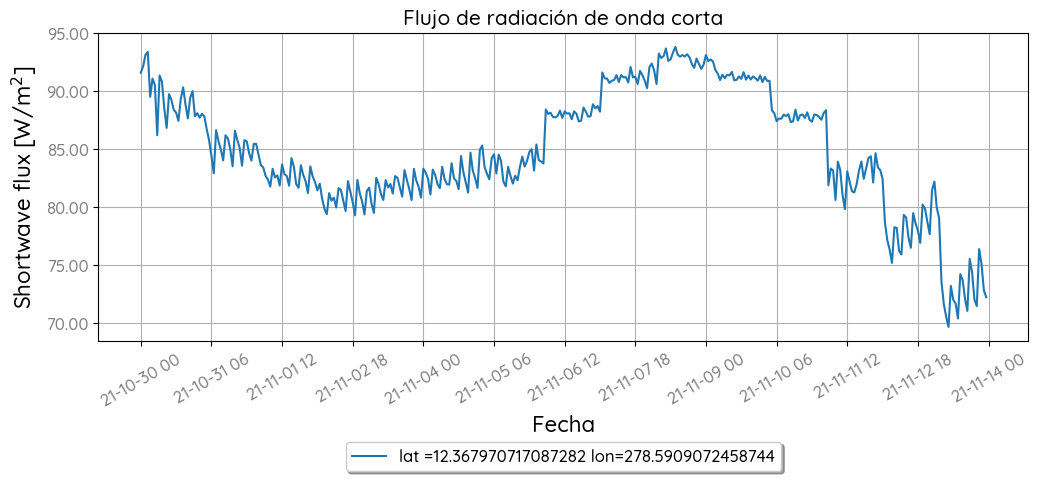

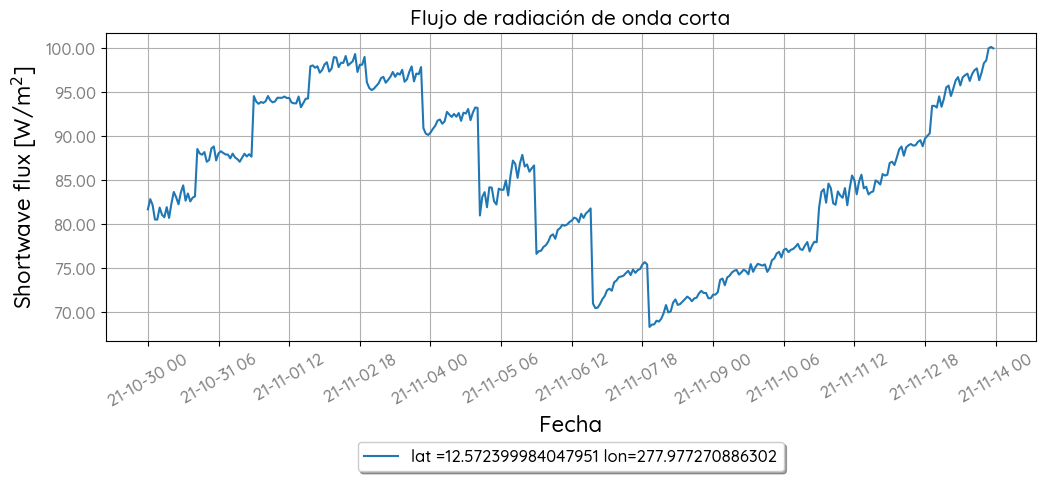

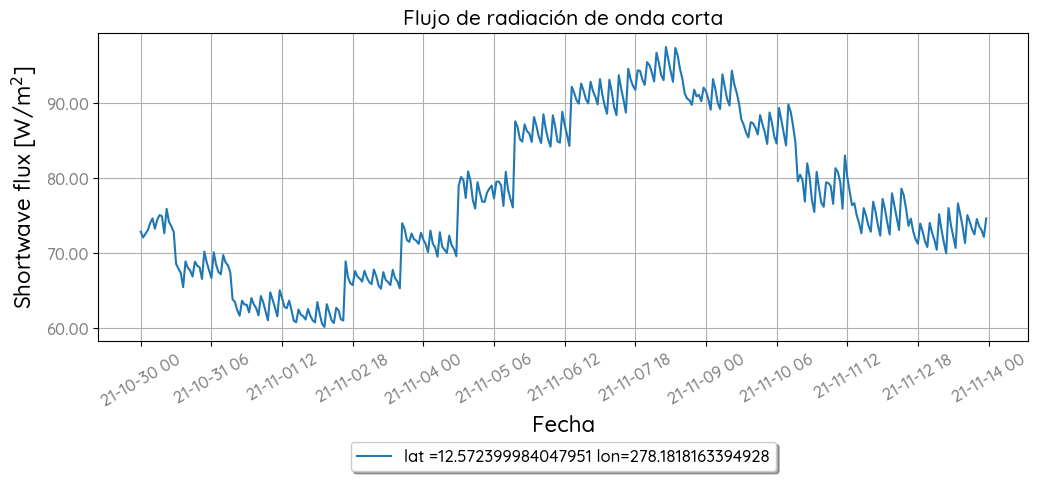

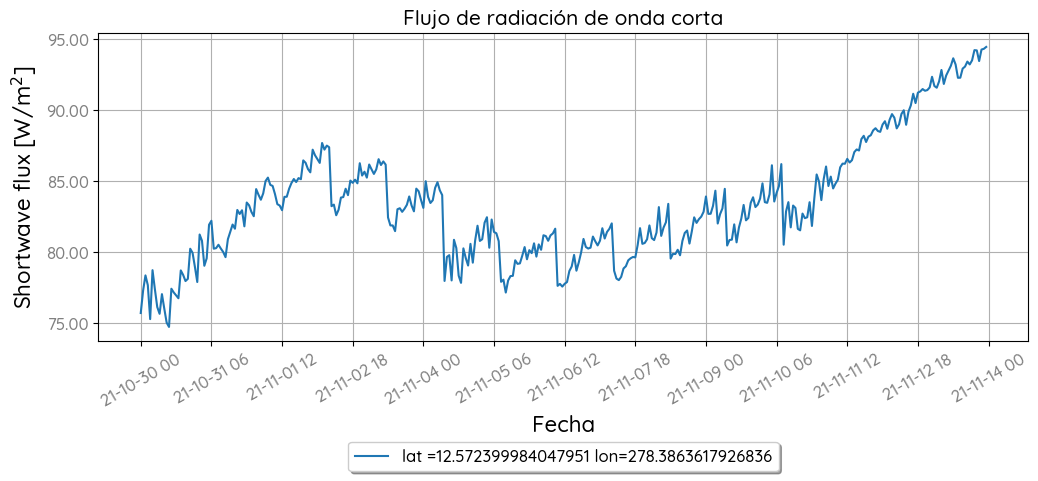

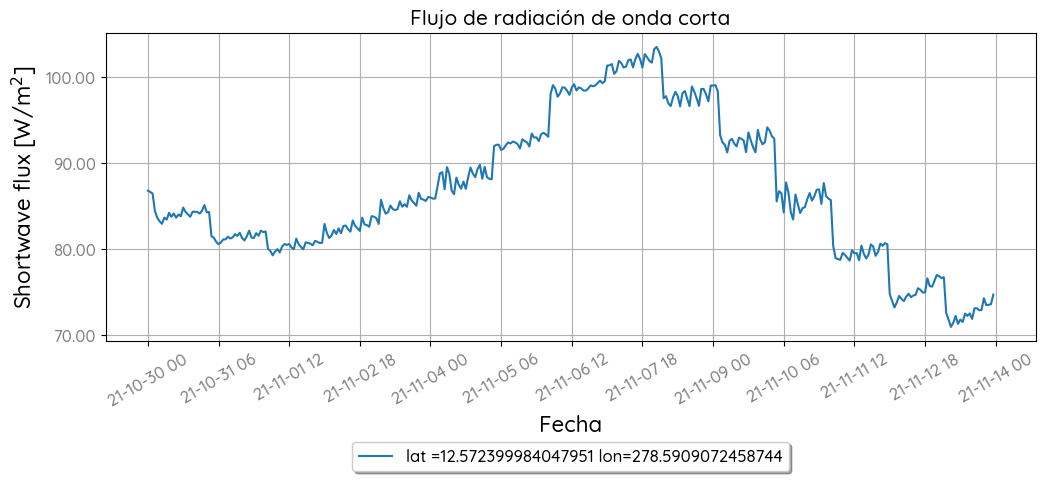

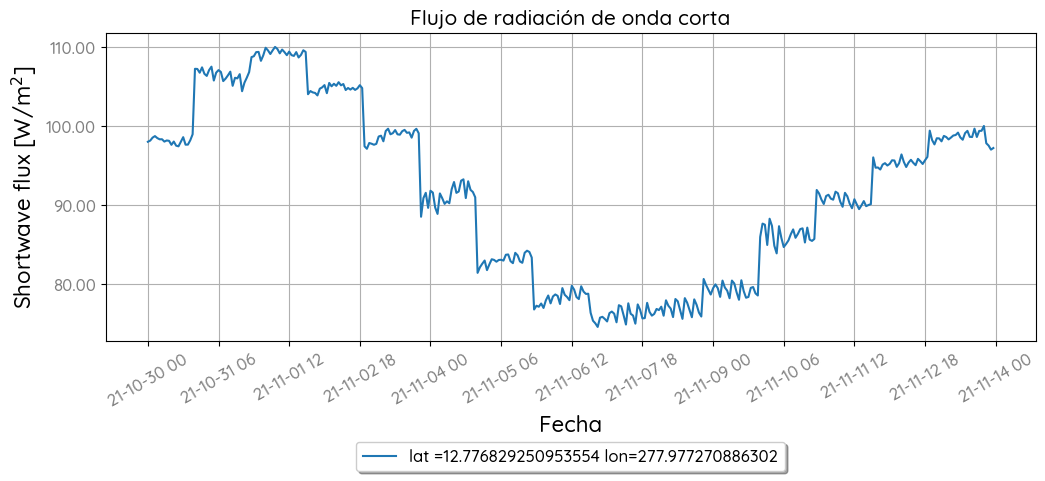

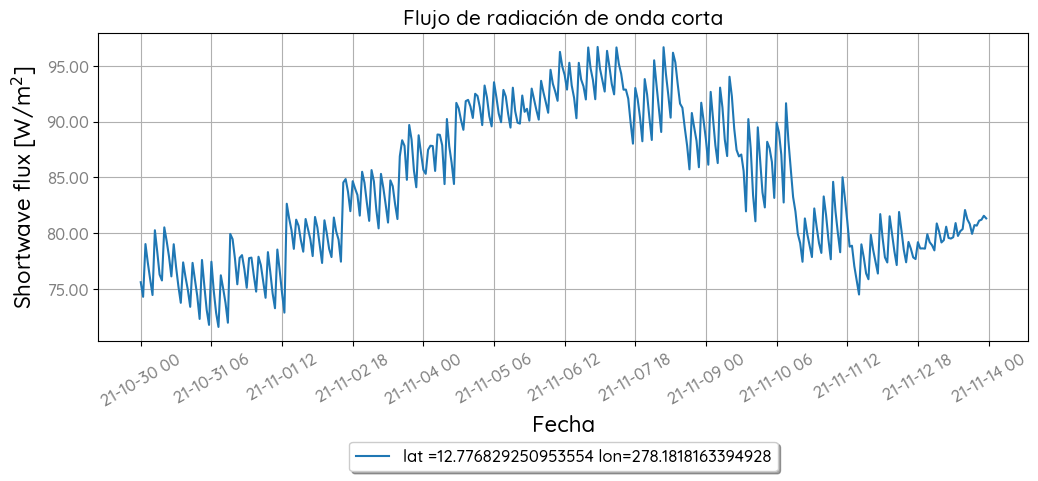

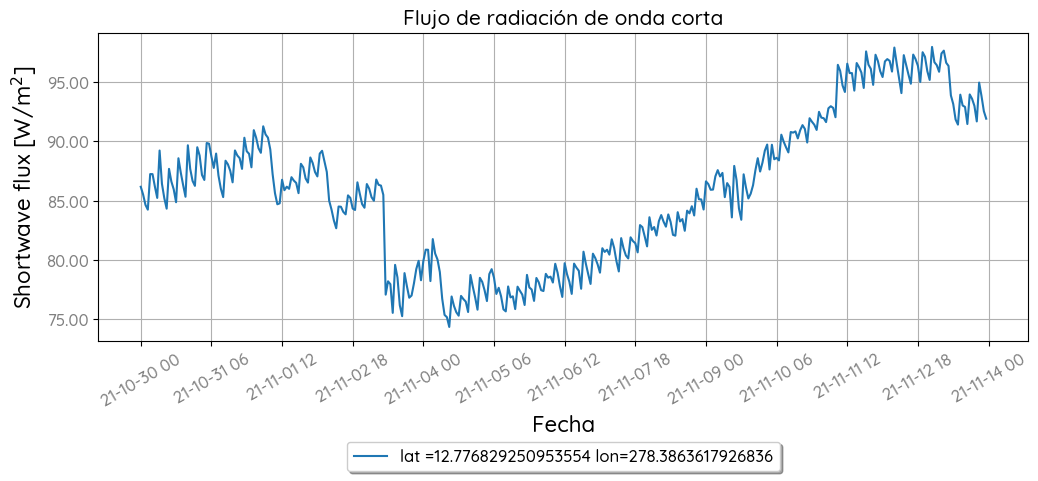

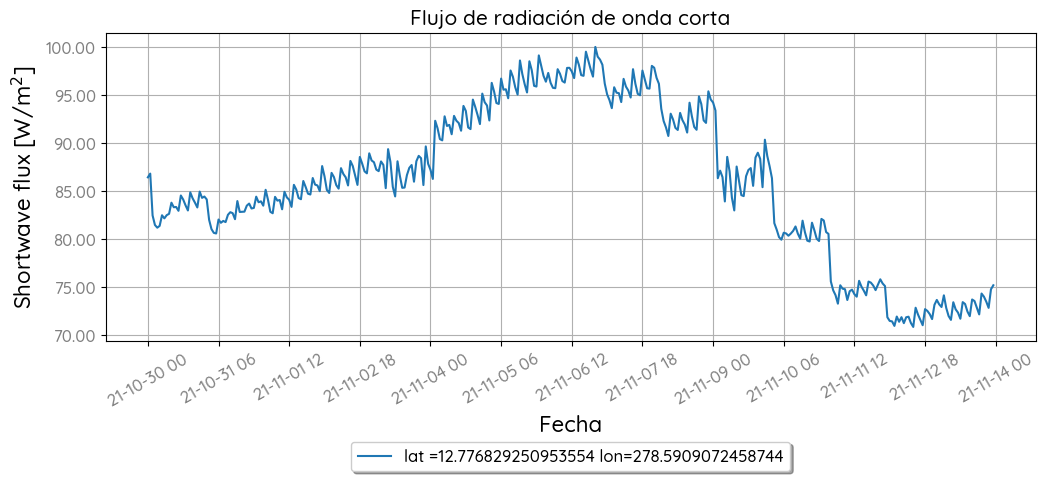

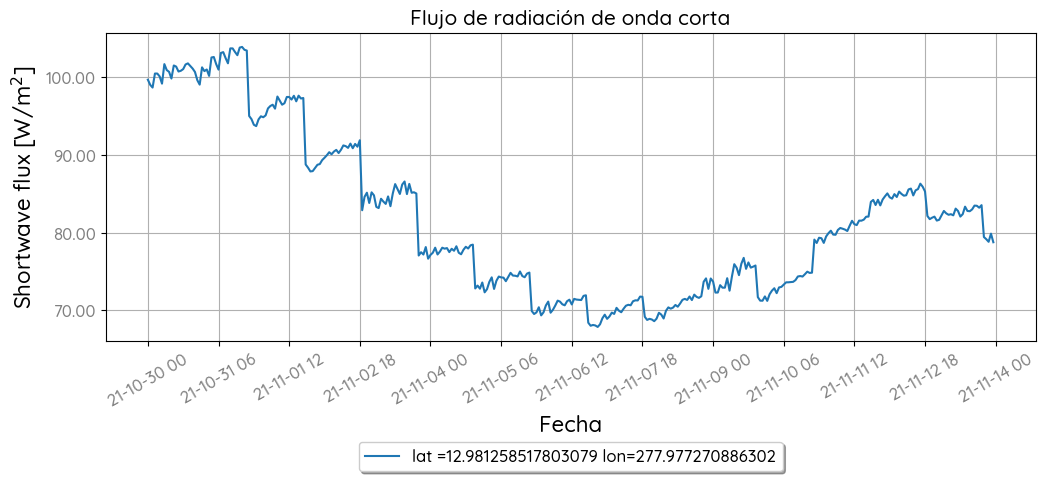

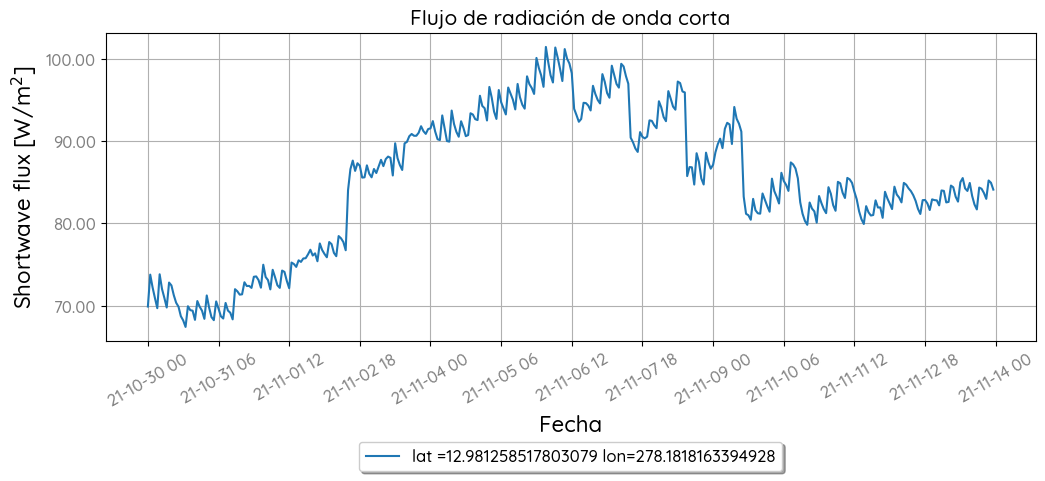

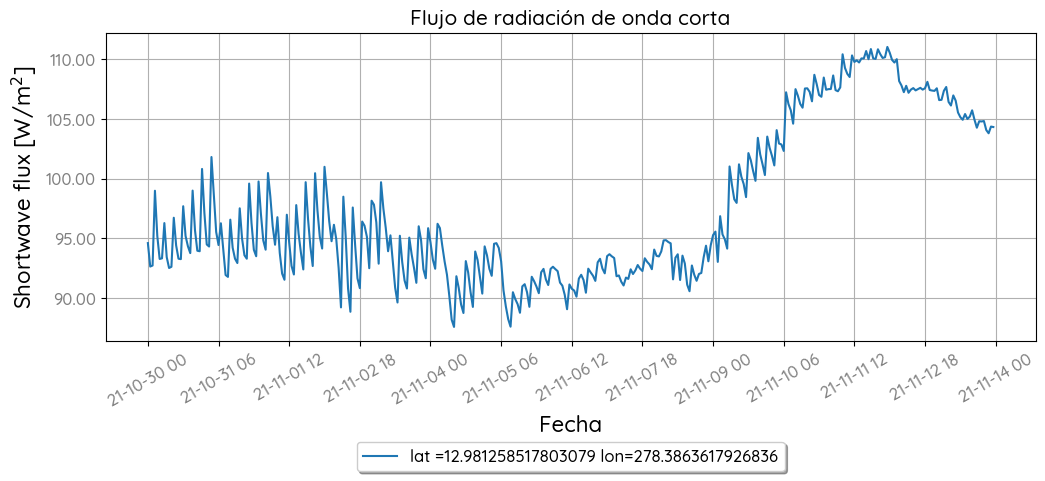

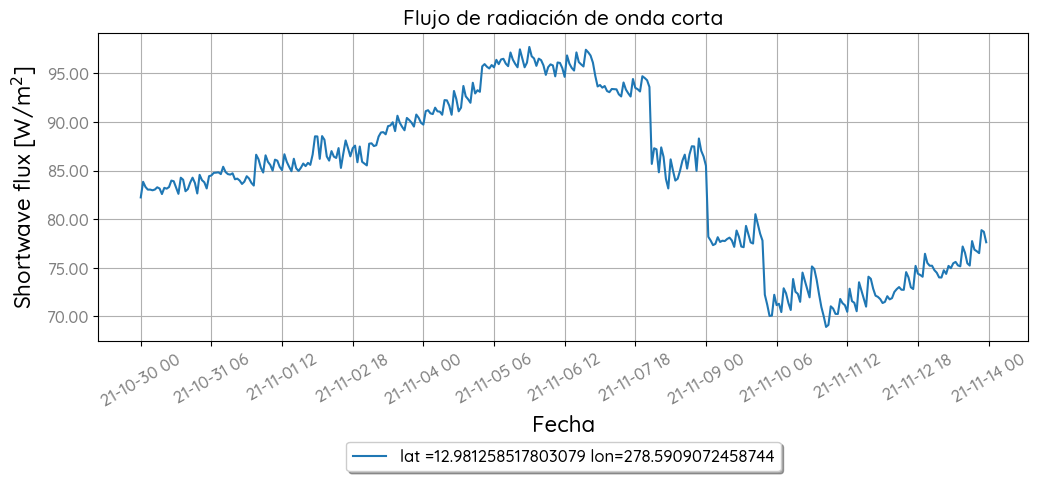

In [43]:
hourticks = ((time_heat[-1]-time_heat[0]).days*24 +(time_heat[-1]-time_heat[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_heat[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

for i in range(len(lat)):
    for j in range(len(lon)):
        fig, ax = plt.subplots(figsize=(12,4))
        ax.plot(time_heat, RH[j,i,ind_ini_fin[0]:ind_ini_fin[1]], label = 'lat ='+str(lat[i]) + ' lon=' + str(lon[j]))
        ax.set_xticks(xticks_time)
        date_format = mdates.DateFormatter('%y-%m-%d %H')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
        ax.set_ylabel ('Shortwave flux [W/m$^2$]',size=16,fontproperties=prop1)
        ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
        for label in ax.get_xticklabels():
            label.set_fontproperties(prop1)
            label.set_color('gray')
            label.set_size(12)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_title('Flujo de radiación de onda corta',size = 15,fontproperties=prop1)   # Subtítulo de la figura
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
        plt.xticks(rotation=30)
        ax.grid(True)